# EEGNet with LSTM

This notebook provides a modified reimplementation of the previously tested CNN-based EEG classifiers:
   - EEGNet by [Lawhern et al](http://iopscience.iop.org/article/10.1088/1741-2552/aace8c/meta).
      - Modifications to make it better suited for short-length windows
      - Memory is added after the "feature extraction" layers, the CNN layers, in the form of a LSTM layer

This notebook works in an offline fashion and uses epochs with a length of 3 seconds.
This epoch starts 1 second before the visual queue was given, includes the 1 second the visual queue was shown and ends 1 second after the visual queue was hidden, totalling 3 seconds.
No baseline correction was performed and the raw EEG data was used.
The effective training and testing are done in a half-second window, starting 0.1 seconds after the start of the visual queue.
A window of 0.5 seconds was chosen as it is a common size for sliding window approaches in online systems.
Some alternatives to this setup were also considered, including one alternative performed for all experiment which uses a long, 1.5 seconds, window.


Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. We will use the utility file `bci-master-thesis/code/utils/CLA_dataset.py` to work with this data. The data was stored as FIF files, which are included in [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

<hr><hr>

## Table of Contents

- Checking requirements
   - Correct Anaconda environment
   - Correct module access
   - Correct file access
   - Checking TensorFlow support
- Same subject, same session: EEGNet bidirectional LSTM
   - Results
- Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D
   - Results

<hr><hr>

## Checking requirements

### Correct Anaconda environment

The `bci-master-thesis` Anaconda environment should be active to ensure proper support. Installation instructions are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis).

In [1]:
####################################################
# CHECKING FOR RIGHT ANACONDA ENVIRONMENT
####################################################

import os
from platform import python_version
from pathlib import Path
from copy import copy

print(f"Active environment: {os.environ['CONDA_DEFAULT_ENV']}")
print(f"Correct environment: {os.environ['CONDA_DEFAULT_ENV'] == 'bci-master-thesis'}")
print(f"\nPython version: {python_version()}")
print(f"Correct Python version: {python_version() == '3.8.10'}")

Active environment: bci-master-thesis
Correct environment: True

Python version: 3.8.10
Correct Python version: True


<hr>

### Correct module access

The following code block will load in all required modules.

In [2]:
####################################################
# LOADING MODULES
####################################################

# allow reloading of libraries
import importlib

# Load util function file
import sys
sys.path.append('../utils')
import CLA_dataset
import TF_tools
importlib.reload(CLA_dataset)
importlib.reload(TF_tools)

# IO functions
from IPython.utils import io

# Set logging level for MNE before loading MNE
os.environ['MNE_LOGGING_LEVEL'] = 'WARNING'

# Modules tailored for EEG data
import mne; print(f"MNE version (1.0.2 recommended): {mne.__version__}")

# EEGNet model
import EEGNet_with_lstm
from EEGNet_with_lstm import EEGNet_bidirectional_lstm, EEGNet_lstm_1Dconv

# Data manipulation modules
import numpy as np; print(f"Numpy version (1.21.5 recommended): {np.__version__}")
import pandas as pd; print(f"Pandas version (1.4.1 recommended): {pd.__version__}")
import copy

# ML libraries
import sklearn;  print(f"Scikit-learn version (1.0.2 recommended): {sklearn.__version__}")
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score
from sklearn.preprocessing import OneHotEncoder

# Deep Learning libraries
import tensorflow as tf;  print(f"TensorFlow version (2.8.0 recommended): {tf.__version__}")

import keras; print(f"Keras version (2.8.0 recommended): {keras.__version__}")
from keras.callbacks import ModelCheckpoint

# Storing files
import pickle;  print(f"Pickle version (4.0 recommended): {pickle.format_version}")

# Plotting
import matplotlib; print(f"Matplotlib version (3.5.1 recommended): {matplotlib.__version__}")
import matplotlib.pyplot as plt

MNE version (1.0.2 recommended): 1.0.2
Numpy version (1.21.5 recommended): 1.21.5
Pandas version (1.4.1 recommended): 1.4.1
Scikit-learn version (1.0.2 recommended): 1.0.2
TensorFlow version (2.8.0 recommended): 2.8.0
Keras version (2.8.0 recommended): 2.8.0
Pickle version (4.0 recommended): 4.0
Matplotlib version (3.5.1 recommended): 3.5.1


<hr>

### Correct file access

As mentioned, this notebook uses a database provided by [Kaya et al](https://doi.org/10.1038/sdata.2018.211). The CLA dataset in particular. Instructions on where to get the data are available on [the GitHub repository of the BCI master thesis project](https://www.github.com/pikawika/bci-master-thesis). These instructions are under `bci-master-thesis/code/data/CLA/README.md`. The following code block checks if all required files are available.

In [3]:
####################################################
# CHECKING FILE ACCESS
####################################################

# Use util to determine if we have access
print("Full Matlab CLA file access: " + str(CLA_dataset.check_matlab_files_availability()))
print("Full MNE CLA file access: " + str(CLA_dataset.check_mne_files_availability()))

Full Matlab CLA file access: True
Full MNE CLA file access: True


<hr>

### Checking TensorFlow support

If you want to use TensorFlow with GPU acceleration, the below codeblock can help you gather insight.

To launch the tensorboard use the following command in the `paper-notebooks` folder, be sure to have the right environments active:
- Windows: `tensorboard --logdir=./logs/`
- MacOS: `tensorboard --logdir='./logs/'`

In [4]:
TF_tools.check_tf_cpu_gpu_presence()

There are 1 CPUs available under the names:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


There are 1 GPUs available under the names:
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


<hr><hr>

## Same subject, same session: EEGNet bidirectional LSTM 

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 1000 epochs, knowing it would overfit pretty quickly, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [5]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = False # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_bidirectional_lstm_model = EEGNet_bidirectional_lstm(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    F2 = 16, # number of pointwise filters. (default: 16)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    LSTM_size = 64, # Amount of units in LSTM layer
    ltsm_dropout = 0.5
        )

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstm_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_bidirectional_lstm_model)
                
                # Compile the model so it can be fitted (loss and optimizer from EEGNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_bidirectional_lstm_model

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with biderectional LSTM:

| **Subject** | **EEGNet LSTM: best validation accuracy** | **EEGNet LSTM: best validation loss** | **EEGNet LSTM: test split accuracy (best acc model)** | **EEGNet LSTM: test split accuracy (best loss model)** |
|-------------|-------------------------------------------|---------------------------------------|-------------------------------------------------------|--------------------------------------------------------|
| B           | 0.8073 @ epoch 426                        | 0.5242 @ epoch 293                    | 0.7344                                                | 0.724                                                  |
| C           | 0.9062 @ epoch 720                        | 0.432 @ epoch 139                     | 0.8698                                                | 0.8646                                                 |
| E           | 0.9267                                    | 0.2477                                | 0.8639                                                | 0.8586                                                 |

With very comparable results it is clear that the extension didn't yield improvements nor caused any issues.
This might suggest that there is just not more information in the data since all results from all these complex models are so comparable for this experiment type.
One noticeable thing is that there is a far greater chance on overfitting, requiring far more extreme dropout.
However, the experiment setup stores both the model with the best validation accuracy and best loss accuracy, so the final obtained models are not really influenced by overfitting behaviour.
The longer windows might aid in reducing this overfitting phenomenon due to the greater amount of data.


![Accuracy plot](figures/7/EEGNet_lstm/samesubject_samesession/accuracy.png)
![Loss plot](figures/7/EEGNet_lstm/samesubject_samesession/loss.png)


####################################################
# RESULTS FOR SUBJECT B
####################################################

#### results of training ####
Best training accuracy (max) 0.8611 @ epoch 866
Best training loss (min) 0.3936 @ epoch 922

Best validation accuracy (max) 0.8073 @ epoch 426
Best validation loss (min) 0.5242 @ epoch 293

#### results for highest accuracy model ####
Accuracy of: 0.7344


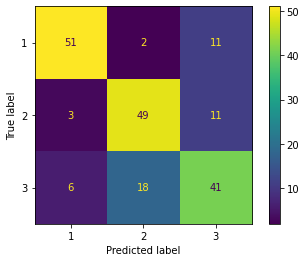


#### results for lowest loss model ####
Accuracy of: 0.724


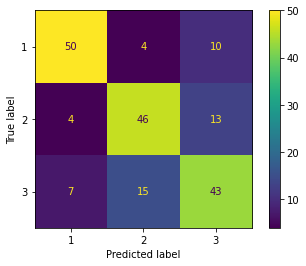


####################################################
# RESULTS FOR SUBJECT C
####################################################

#### results of training ####
Best training accuracy (max) 0.9617 @ epoch 993
Best training loss (min) 0.1409 @ epoch 993

Best validation accuracy (max) 0.9062 @ epoch 720
Best validation loss (min) 0.432 @ epoch 139

#### results for highest accuracy model ####
Accuracy of: 0.8698


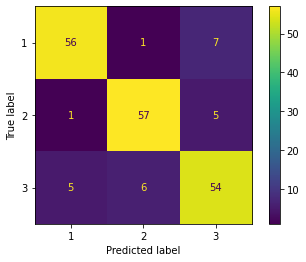


#### results for lowest loss model ####
Accuracy of: 0.8646


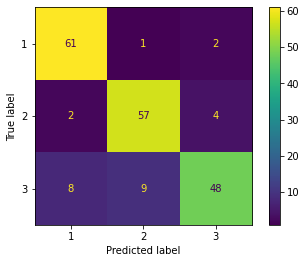


####################################################
# RESULTS FOR SUBJECT E
####################################################

#### results of training ####
Best training accuracy (max) 0.9319 @ epoch 959
Best training loss (min) 0.2045 @ epoch 992

Best validation accuracy (max) 0.9267 @ epoch 748
Best validation loss (min) 0.2477 @ epoch 674

#### results for highest accuracy model ####
Accuracy of: 0.8639


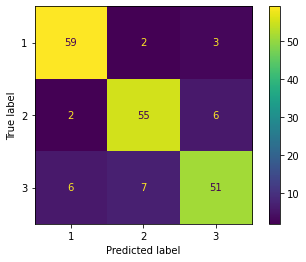


#### results for lowest loss model ####
Accuracy of: 0.8586


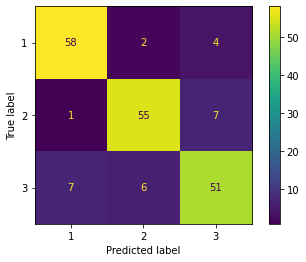

In [6]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstm/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id

<hr><hr>

## Same subject, same session: ShallowConvNet with bidirectional ConvLSTM2D

As discussed in the master's thesis, training and testing a classification system can happen using multiple strategies.
A classifier may be trained on a singular subject, using a singular session and testing on that same session.
This is an over-optimistic testing scenario and has a great risk of overfitting with poor generalisation to new sessions or new subjects but can be an okay baseline test to see if *at least something* can be learned.
Just like we did for the CSP approaches, we do this for the EEGNet model as well.


This experiment works as follows:
   - We use participants with at least three recordings
      - Participants: B, C, E
      - NOTE: participant F has three files provided but one of those files has only three MI classes rather than three, hence it is not considered here
   - We use the last recorded session of each of these participants, thus the one where the participant has the most experience
   - We get epochs of 3 seconds, which includes one second before and after the visual queue
      - We use only a half a second window taking into account the online system will use sliding windows.
      - This window starts at 0.1 seconds after then visual queue and ends at 0.6 seconds after the visual queue
   - We split the data in a train/test dataset with 20% test data balanced over all MI classes
   - We use the parameters for EEGNet as found in the experimental notebook `6-DL-based-classification.ipynb`:
      - We input the raw data, which is not baseline corrected, but multiply it by 1000000 to combat the scaling that MNE does per default.
         - This means that we only use the data from the window, so it is easier adoptable to a live setting.
      - We used the modified EEGNet model with memory provided through the `EEGNet_with_lstm.py` util file with the following settings:
         - nb_classes = 3 (int, number of classes to classify)
         - Chans = 21 (number of channels in the EEG dat)
         - Samples = 100 (number of time points in the EEG data - default: 128)
         - dropoutRate = 0.5 (dropout fraction - default: 0.5)
         - kernLength = 50 (length of temporal convolution in first layer. Suggested: half the sampling rate - default: 64)
         - F1 = 8 (number of temporal filters - default: 8)
         - F2 = 16 (number of pointwise filters - default: 16)
         - D = 2 (number of spatial filters to learn within each temporal convolution - default: 2)
         - norm_rate = 0.25 (Normalisation rate - default: 0.25)
         - dropoutType = 'SpatialDropout2D' (Either SpatialDropout2D or Dropout, passed as a string - default: Dropout)
      - We trained for 2500 epochs, saving the best model based on best validation accuracy and validation loss (0.25 validation split - equal size as true test split)
   - We record the validation accuracy and loss over time for monitoring the training and test on the seperate test set

In [6]:
####################################################
# TRAINING EEGNET FOR EACH SUBJECT AND SESSION
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings
start_offset = -1 # One second before visual queue
end_offset = 1 # One second after visual queue
baseline = None # Baseline correction using data before the visual queue

do_experiment = True # Long experiment disabled per default

# Create the TensorFlow Keras model
keras_eegnet_lstm_1Dconv_model = EEGNet_lstm_1Dconv(
    nb_classes = 3, # int, number of classes to classify. 
    Chans = 21, # number of channels in the EEG data. 
    Samples = 100, # number of time points in the EEG data. (default: 128)
    dropoutRate = 0.5, # dropout fraction. (default: 0.5)
    kernLength = 50, # length of temporal convolution in first layer. Suggested: half the sampling rate. (default: 64)
    F1 = 8, # number of temporal filters. (default: 8)
    D = 2, # number of spatial filters to learn within each temporal convolution. (default: 2)
    norm_rate = 0.25, # Normalisation rate. (default: 0.25)
    dropoutType = 'SpatialDropout2D', # Either SpatialDropout2D or Dropout, passed as a string. (default: Dropout)
    lstm_filters = 64, # Amount of filters for LSTM layer Conv1D. Default: 32
    lstm_kernel_size = 4, # Kernels size for LSTM layer Conv1D.
    ltsm_dropout= 0.5,
    ltsm_l1 = 0, ltsm_l2 = 0
)

if do_experiment:
        # Loop over all subjects and perform the grid search for finding the best parameters
        for subject_id in subject_ids_to_test:
                print("")
                print("####################################################")
                print(f"# TRAINING FOR SUBJECT {subject_id}")
                print("####################################################")
                print("")
                ###################### PREPARE DATA ######################
                
                with io.capture_output():
                        # Get MNE raw object for latest recording of that subject
                        mne_raw = CLA_dataset.get_last_raw_mne_data_for_subject(subject_id= subject_id)
                        
                        # Get epochs for that MNE raw
                        mne_epochs = CLA_dataset.get_usefull_epochs_from_raw(mne_raw,
                                                                             start_offset= start_offset,
                                                                             end_offset= end_offset,
                                                                             baseline= baseline)
                        
                        # Only keep epochs from the MI tasks
                        mne_epochs = mne_epochs['task/neutral', 'task/left', 'task/right']
                        
                        # Load epochs into memory
                        mne_epochs.load_data()
                
                # Get the labels
                labels = mne_epochs.events[:, -1]
                
                # Convert the labels to OHE labels as needed for Keras
                labels = labels.reshape(-1, 1)
                ohe = OneHotEncoder()
                labels = ohe.fit_transform(labels).toarray()
                
                # Get a half second window
                mne_epochs_data = mne_epochs.get_data(tmin= 0.1, tmax= 0.6)
                
                # Fix scaling sensitivity as MNE stores as data * 10e-6
                mne_epochs_data = mne_epochs_data * 1000000
                
                # Create a test and train split
                X_train, X_test, y_train, y_test = train_test_split(mne_epochs_data,
                                                                    labels,
                                                                    test_size = 0.2,
                                                                    shuffle= True,
                                                                    stratify= labels,                                                    
                                                                    random_state= 1998)
                
                
                
                # Store the train and test data so the best model can be retrained later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'wb') as file:
                        pickle.dump(X_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'wb') as file:
                        pickle.dump(y_test, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-x.pickle", 'wb') as file:
                        pickle.dump(X_train, file)
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/traindata-y.pickle", 'wb') as file:
                        pickle.dump(y_train, file)
                        
                # Store the OHE encoder to enable same conversion later
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'wb') as file:
                        pickle.dump(ohe, file)
                        
                print(f"Shape of all data (epochs, channels, samples): {np.shape(mne_epochs_data)}")
                print(f"Shape of train data (epochs, channels, samples): {np.shape(X_train)}")
                print(f"Shape of test data (epochs, channels, samples): {np.shape(X_test)}")
                
                
                ###################### PREPARE MODEL ######################
                
                # Names for model
                best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model" 
                tensorboard_name = f"paper-notebook7_eegnetlstmconv_singlesession_subject{subject_id}" # log name for tensorboard
                
                # Create copy of the model that needs training
                # Create copy of the model that needs training
                trained_model = keras.models.clone_model(keras_eegnet_lstm_1Dconv_model)
                
                # Compile the model so it can be fitted (loss and optimizer from ShallowConvNet paper)
                trained_model.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics=["accuracy"])
                
                # Train model with GPU
                # NOTE: change GPU to CPU if no GPU present
                with tf.device('/gpu:0'):
                        history = trained_model.fit(
                                x= X_train,
                                y= y_train,
                                batch_size= 128, # Default: 32
                                epochs= 1000, # Default: 500 (EEGNet paper)
                                verbose= 1, # 0 = silent, 1 = progress bar, 2 = one line per epoch
                                callbacks= [TF_tools.tensorboard_callback(log_name= tensorboard_name),
                                            TF_tools.lowest_loss_model_save_callback(filepath= best_base_model_filename),
                                            TF_tools.highest_accuracy_model_save_callback(filepath= best_base_model_filename)],
                                validation_split= 0.25,
                                shuffle= True,
                                sample_weight= None, # Can be interesting due to time series
                                use_multiprocessing=True, # Done for faster speed
                                workers= 4 # Done for faster speed
                                )
                        
                # Store the fitting history
                with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'wb') as file:
                        pickle.dump(history.history, file)
                
                # Delete vars after singular experiment
                del mne_raw
                del mne_epochs
                del mne_epochs_data
                del trained_model
                del best_base_model_filename
                del tensorboard_name
                del labels
                del file
                del history
                del X_train
                del X_test
                del ohe
                del y_train
                del y_test
    
        # Delete vars after all experiments
        del subject_id
        
# Del global vars
del subject_ids_to_test
del baseline
del do_experiment
del end_offset
del start_offset
del keras_eegnet_lstm_1Dconv_model


####################################################
# TRAINING FOR SUBJECT B
####################################################

Shape of all data (epochs, channels, samples): (960, 21, 100)
Shape of train data (epochs, channels, samples): (768, 21, 100)
Shape of test data (epochs, channels, samples): (192, 21, 100)
Epoch 1/1000
5/5 [==============================] - ETA: 0s - loss: 1.0966 - accuracy: 0.3837
Epoch 1: val_loss improved from inf to 1.05671, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 1: val_accuracy improved from -inf to 0.40625, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 30s 5s/step - loss: 1.0966 - accuracy: 0.3837 - val_loss: 1.0567 - val_accuracy: 0.4062
Epoch 2/1000
5/5 [==============================] - ETA: 0s - loss: 1.0500 - accuracy: 0.5226
Epoch 2: val_loss

Epoch 15/1000
5/5 [==============================] - ETA: 0s - loss: 0.5822 - accuracy: 0.7622
Epoch 15: val_loss improved from 0.67374 to 0.67166, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectB\trained_model_lowest_loss_model.hdf5

Epoch 15: val_accuracy did not improve from 0.74479
5/5 [==============================] - 22s 5s/step - loss: 0.5822 - accuracy: 0.7622 - val_loss: 0.6717 - val_accuracy: 0.7344
Epoch 16/1000
5/5 [==============================] - ETA: 0s - loss: 0.5823 - accuracy: 0.7622
Epoch 16: val_loss did not improve from 0.67166

Epoch 16: val_accuracy did not improve from 0.74479
5/5 [==============================] - 22s 5s/step - loss: 0.5823 - accuracy: 0.7622 - val_loss: 0.6753 - val_accuracy: 0.7344
Epoch 17/1000
5/5 [==============================] - ETA: 0s - loss: 0.5481 - accuracy: 0.7674
Epoch 17: val_loss improved from 0.67166 to 0.64774, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/sub


Epoch 38: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 5s/step - loss: 0.3584 - accuracy: 0.8681 - val_loss: 0.8363 - val_accuracy: 0.6615
Epoch 39/1000
5/5 [==============================] - ETA: 0s - loss: 0.3580 - accuracy: 0.8681
Epoch 39: val_loss did not improve from 0.64453

Epoch 39: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 5s/step - loss: 0.3580 - accuracy: 0.8681 - val_loss: 0.7519 - val_accuracy: 0.7083
Epoch 40/1000
5/5 [==============================] - ETA: 0s - loss: 0.3500 - accuracy: 0.8490
Epoch 40: val_loss did not improve from 0.64453

Epoch 40: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 4s/step - loss: 0.3500 - accuracy: 0.8490 - val_loss: 0.7316 - val_accuracy: 0.7396
Epoch 41/1000
5/5 [==============================] - ETA: 0s - loss: 0.3134 - accuracy: 0.8767
Epoch 41: val_loss did not improve from 0.64453

Epoch 41: val_accuracy did not

Epoch 64/1000
5/5 [==============================] - ETA: 0s - loss: 0.2562 - accuracy: 0.8976
Epoch 64: val_loss did not improve from 0.64453

Epoch 64: val_accuracy did not improve from 0.76562
5/5 [==============================] - 21s 4s/step - loss: 0.2562 - accuracy: 0.8976 - val_loss: 1.0576 - val_accuracy: 0.7135
Epoch 65/1000
5/5 [==============================] - ETA: 0s - loss: 0.2154 - accuracy: 0.9271
Epoch 65: val_loss did not improve from 0.64453

Epoch 65: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 4s/step - loss: 0.2154 - accuracy: 0.9271 - val_loss: 1.0815 - val_accuracy: 0.7083
Epoch 66/1000
5/5 [==============================] - ETA: 0s - loss: 0.2038 - accuracy: 0.9306
Epoch 66: val_loss did not improve from 0.64453

Epoch 66: val_accuracy did not improve from 0.76562
5/5 [==============================] - 21s 4s/step - loss: 0.2038 - accuracy: 0.9306 - val_loss: 1.0800 - val_accuracy: 0.6927
Epoch 67/1000
5/5 [============


Epoch 89: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 5s/step - loss: 0.1869 - accuracy: 0.9323 - val_loss: 1.1011 - val_accuracy: 0.7396
Epoch 90/1000
5/5 [==============================] - ETA: 0s - loss: 0.1656 - accuracy: 0.9479
Epoch 90: val_loss did not improve from 0.64453

Epoch 90: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 4s/step - loss: 0.1656 - accuracy: 0.9479 - val_loss: 1.1076 - val_accuracy: 0.7292
Epoch 91/1000
5/5 [==============================] - ETA: 0s - loss: 0.1668 - accuracy: 0.9410
Epoch 91: val_loss did not improve from 0.64453

Epoch 91: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 4s/step - loss: 0.1668 - accuracy: 0.9410 - val_loss: 1.0593 - val_accuracy: 0.7240
Epoch 92/1000
5/5 [==============================] - ETA: 0s - loss: 0.1466 - accuracy: 0.9427
Epoch 92: val_loss did not improve from 0.64453

Epoch 92: val_accuracy did not

Epoch 115/1000
5/5 [==============================] - ETA: 0s - loss: 0.1194 - accuracy: 0.9531
Epoch 115: val_loss did not improve from 0.64453

Epoch 115: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 5s/step - loss: 0.1194 - accuracy: 0.9531 - val_loss: 1.1331 - val_accuracy: 0.7396
Epoch 116/1000
5/5 [==============================] - ETA: 0s - loss: 0.1162 - accuracy: 0.9531
Epoch 116: val_loss did not improve from 0.64453

Epoch 116: val_accuracy did not improve from 0.76562
5/5 [==============================] - 21s 4s/step - loss: 0.1162 - accuracy: 0.9531 - val_loss: 1.1290 - val_accuracy: 0.7292
Epoch 117/1000
5/5 [==============================] - ETA: 0s - loss: 0.1391 - accuracy: 0.9583
Epoch 117: val_loss did not improve from 0.64453

Epoch 117: val_accuracy did not improve from 0.76562
5/5 [==============================] - 23s 5s/step - loss: 0.1391 - accuracy: 0.9583 - val_loss: 1.1272 - val_accuracy: 0.7344
Epoch 118/1000
5/5 [==

5/5 [==============================] - ETA: 0s - loss: 0.1151 - accuracy: 0.9566
Epoch 165: val_loss did not improve from 0.64453

Epoch 165: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 5s/step - loss: 0.1151 - accuracy: 0.9566 - val_loss: 1.2399 - val_accuracy: 0.7292
Epoch 166/1000
5/5 [==============================] - ETA: 0s - loss: 0.0810 - accuracy: 0.9670
Epoch 166: val_loss did not improve from 0.64453

Epoch 166: val_accuracy did not improve from 0.76562
5/5 [==============================] - 21s 4s/step - loss: 0.0810 - accuracy: 0.9670 - val_loss: 1.2200 - val_accuracy: 0.7188
Epoch 167/1000
5/5 [==============================] - ETA: 0s - loss: 0.1092 - accuracy: 0.9653
Epoch 167: val_loss did not improve from 0.64453

Epoch 167: val_accuracy did not improve from 0.76562
5/5 [==============================] - 22s 4s/step - loss: 0.1092 - accuracy: 0.9653 - val_loss: 1.2412 - val_accuracy: 0.7500
Epoch 168/1000
5/5 [=================

Epoch 215/1000
5/5 [==============================] - ETA: 0s - loss: 0.0830 - accuracy: 0.9722
Epoch 215: val_loss did not improve from 0.64453

Epoch 215: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0830 - accuracy: 0.9722 - val_loss: 1.3740 - val_accuracy: 0.7292
Epoch 216/1000
5/5 [==============================] - ETA: 0s - loss: 0.0978 - accuracy: 0.9618
Epoch 216: val_loss did not improve from 0.64453

Epoch 216: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0978 - accuracy: 0.9618 - val_loss: 1.3886 - val_accuracy: 0.7396
Epoch 217/1000
5/5 [==============================] - ETA: 0s - loss: 0.0724 - accuracy: 0.9740
Epoch 217: val_loss did not improve from 0.64453

Epoch 217: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0724 - accuracy: 0.9740 - val_loss: 1.3849 - val_accuracy: 0.7292
Epoch 218/1000
5/5 [==

5/5 [==============================] - ETA: 0s - loss: 0.0405 - accuracy: 0.9878
Epoch 265: val_loss did not improve from 0.64453

Epoch 265: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0405 - accuracy: 0.9878 - val_loss: 1.5352 - val_accuracy: 0.7083
Epoch 266/1000
5/5 [==============================] - ETA: 0s - loss: 0.0501 - accuracy: 0.9844
Epoch 266: val_loss did not improve from 0.64453

Epoch 266: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0501 - accuracy: 0.9844 - val_loss: 1.4740 - val_accuracy: 0.7031
Epoch 267/1000
5/5 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9774
Epoch 267: val_loss did not improve from 0.64453

Epoch 267: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0762 - accuracy: 0.9774 - val_loss: 1.4301 - val_accuracy: 0.7135
Epoch 268/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0652 - accuracy: 0.9722
Epoch 315: val_loss did not improve from 0.64453

Epoch 315: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0652 - accuracy: 0.9722 - val_loss: 1.5527 - val_accuracy: 0.7396
Epoch 316/1000
5/5 [==============================] - ETA: 0s - loss: 0.0469 - accuracy: 0.9844
Epoch 316: val_loss did not improve from 0.64453

Epoch 316: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0469 - accuracy: 0.9844 - val_loss: 1.5097 - val_accuracy: 0.7396
Epoch 317/1000
5/5 [==============================] - ETA: 0s - loss: 0.0570 - accuracy: 0.9774
Epoch 317: val_loss did not improve from 0.64453

Epoch 317: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0570 - accuracy: 0.9774 - val_loss: 1.5189 - val_accuracy: 0.7292
Epoch 318/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0419 - accuracy: 0.9878
Epoch 365: val_loss did not improve from 0.64453

Epoch 365: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 5s/step - loss: 0.0419 - accuracy: 0.9878 - val_loss: 1.6671 - val_accuracy: 0.7135
Epoch 366/1000
5/5 [==============================] - ETA: 0s - loss: 0.0443 - accuracy: 0.9826
Epoch 366: val_loss did not improve from 0.64453

Epoch 366: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0443 - accuracy: 0.9826 - val_loss: 1.6945 - val_accuracy: 0.7240
Epoch 367/1000
5/5 [==============================] - ETA: 0s - loss: 0.0624 - accuracy: 0.9774
Epoch 367: val_loss did not improve from 0.64453

Epoch 367: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0624 - accuracy: 0.9774 - val_loss: 1.7866 - val_accuracy: 0.7083
Epoch 368/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0373 - accuracy: 0.9878
Epoch 415: val_loss did not improve from 0.64453

Epoch 415: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0373 - accuracy: 0.9878 - val_loss: 1.7450 - val_accuracy: 0.7083
Epoch 416/1000
5/5 [==============================] - ETA: 0s - loss: 0.0555 - accuracy: 0.9792
Epoch 416: val_loss did not improve from 0.64453

Epoch 416: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0555 - accuracy: 0.9792 - val_loss: 1.7882 - val_accuracy: 0.7135
Epoch 417/1000
5/5 [==============================] - ETA: 0s - loss: 0.0401 - accuracy: 0.9792
Epoch 417: val_loss did not improve from 0.64453

Epoch 417: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0401 - accuracy: 0.9792 - val_loss: 1.8320 - val_accuracy: 0.6927
Epoch 418/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0718 - accuracy: 0.9670
Epoch 465: val_loss did not improve from 0.64453

Epoch 465: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0718 - accuracy: 0.9670 - val_loss: 2.0416 - val_accuracy: 0.7083
Epoch 466/1000
5/5 [==============================] - ETA: 0s - loss: 0.0541 - accuracy: 0.9826
Epoch 466: val_loss did not improve from 0.64453

Epoch 466: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0541 - accuracy: 0.9826 - val_loss: 2.0053 - val_accuracy: 0.7083
Epoch 467/1000
5/5 [==============================] - ETA: 0s - loss: 0.0264 - accuracy: 0.9878
Epoch 467: val_loss did not improve from 0.64453

Epoch 467: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0264 - accuracy: 0.9878 - val_loss: 1.9497 - val_accuracy: 0.7240
Epoch 468/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0358 - accuracy: 0.9861
Epoch 515: val_loss did not improve from 0.64453

Epoch 515: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0358 - accuracy: 0.9861 - val_loss: 1.8143 - val_accuracy: 0.7240
Epoch 516/1000
5/5 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9878
Epoch 516: val_loss did not improve from 0.64453

Epoch 516: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0379 - accuracy: 0.9878 - val_loss: 1.7862 - val_accuracy: 0.7240
Epoch 517/1000
5/5 [==============================] - ETA: 0s - loss: 0.0535 - accuracy: 0.9826
Epoch 517: val_loss did not improve from 0.64453

Epoch 517: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0535 - accuracy: 0.9826 - val_loss: 1.7437 - val_accuracy: 0.7240
Epoch 518/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0372 - accuracy: 0.9844
Epoch 565: val_loss did not improve from 0.64453

Epoch 565: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0372 - accuracy: 0.9844 - val_loss: 1.8057 - val_accuracy: 0.7083
Epoch 566/1000
5/5 [==============================] - ETA: 0s - loss: 0.0353 - accuracy: 0.9896
Epoch 566: val_loss did not improve from 0.64453

Epoch 566: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0353 - accuracy: 0.9896 - val_loss: 1.8379 - val_accuracy: 0.7031
Epoch 567/1000
5/5 [==============================] - ETA: 0s - loss: 0.0239 - accuracy: 0.9931
Epoch 567: val_loss did not improve from 0.64453

Epoch 567: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0239 - accuracy: 0.9931 - val_loss: 1.9137 - val_accuracy: 0.6979
Epoch 568/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9861
Epoch 615: val_loss did not improve from 0.64453

Epoch 615: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0385 - accuracy: 0.9861 - val_loss: 1.8300 - val_accuracy: 0.6875
Epoch 616/1000
5/5 [==============================] - ETA: 0s - loss: 0.0434 - accuracy: 0.9844
Epoch 616: val_loss did not improve from 0.64453

Epoch 616: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0434 - accuracy: 0.9844 - val_loss: 1.8932 - val_accuracy: 0.6823
Epoch 617/1000
5/5 [==============================] - ETA: 0s - loss: 0.0338 - accuracy: 0.9861
Epoch 617: val_loss did not improve from 0.64453

Epoch 617: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0338 - accuracy: 0.9861 - val_loss: 1.9088 - val_accuracy: 0.6927
Epoch 618/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0328 - accuracy: 0.9844
Epoch 665: val_loss did not improve from 0.64453

Epoch 665: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0328 - accuracy: 0.9844 - val_loss: 1.9401 - val_accuracy: 0.7031
Epoch 666/1000
5/5 [==============================] - ETA: 0s - loss: 0.0184 - accuracy: 0.9965
Epoch 666: val_loss did not improve from 0.64453

Epoch 666: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0184 - accuracy: 0.9965 - val_loss: 2.0456 - val_accuracy: 0.6927
Epoch 667/1000
5/5 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9896
Epoch 667: val_loss did not improve from 0.64453

Epoch 667: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0390 - accuracy: 0.9896 - val_loss: 2.0315 - val_accuracy: 0.6771
Epoch 668/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0294 - accuracy: 0.9878
Epoch 715: val_loss did not improve from 0.64453

Epoch 715: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0294 - accuracy: 0.9878 - val_loss: 1.8280 - val_accuracy: 0.7292
Epoch 716/1000
5/5 [==============================] - ETA: 0s - loss: 0.0379 - accuracy: 0.9878
Epoch 716: val_loss did not improve from 0.64453

Epoch 716: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0379 - accuracy: 0.9878 - val_loss: 1.8523 - val_accuracy: 0.7188
Epoch 717/1000
5/5 [==============================] - ETA: 0s - loss: 0.0511 - accuracy: 0.9792
Epoch 717: val_loss did not improve from 0.64453

Epoch 717: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0511 - accuracy: 0.9792 - val_loss: 1.7951 - val_accuracy: 0.7135
Epoch 718/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0321 - accuracy: 0.9861
Epoch 765: val_loss did not improve from 0.64453

Epoch 765: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0321 - accuracy: 0.9861 - val_loss: 1.8144 - val_accuracy: 0.6979
Epoch 766/1000
5/5 [==============================] - ETA: 0s - loss: 0.0319 - accuracy: 0.9931
Epoch 766: val_loss did not improve from 0.64453

Epoch 766: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 5s/step - loss: 0.0319 - accuracy: 0.9931 - val_loss: 1.8401 - val_accuracy: 0.7031
Epoch 767/1000
5/5 [==============================] - ETA: 0s - loss: 0.0369 - accuracy: 0.9861
Epoch 767: val_loss did not improve from 0.64453

Epoch 767: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0369 - accuracy: 0.9861 - val_loss: 2.0104 - val_accuracy: 0.7135
Epoch 768/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0352 - accuracy: 0.9896
Epoch 815: val_loss did not improve from 0.64453

Epoch 815: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0352 - accuracy: 0.9896 - val_loss: 1.9431 - val_accuracy: 0.7083
Epoch 816/1000
5/5 [==============================] - ETA: 0s - loss: 0.0308 - accuracy: 0.9878
Epoch 816: val_loss did not improve from 0.64453

Epoch 816: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0308 - accuracy: 0.9878 - val_loss: 2.0737 - val_accuracy: 0.7083
Epoch 817/1000
5/5 [==============================] - ETA: 0s - loss: 0.0334 - accuracy: 0.9878
Epoch 817: val_loss did not improve from 0.64453

Epoch 817: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0334 - accuracy: 0.9878 - val_loss: 2.0906 - val_accuracy: 0.6823
Epoch 818/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0387 - accuracy: 0.9878
Epoch 865: val_loss did not improve from 0.64453

Epoch 865: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0387 - accuracy: 0.9878 - val_loss: 1.9632 - val_accuracy: 0.6979
Epoch 866/1000
5/5 [==============================] - ETA: 0s - loss: 0.0290 - accuracy: 0.9913
Epoch 866: val_loss did not improve from 0.64453

Epoch 866: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0290 - accuracy: 0.9913 - val_loss: 2.0564 - val_accuracy: 0.6927
Epoch 867/1000
5/5 [==============================] - ETA: 0s - loss: 0.0329 - accuracy: 0.9913
Epoch 867: val_loss did not improve from 0.64453

Epoch 867: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0329 - accuracy: 0.9913 - val_loss: 1.9981 - val_accuracy: 0.6771
Epoch 868/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0340 - accuracy: 0.9896
Epoch 915: val_loss did not improve from 0.64453

Epoch 915: val_accuracy did not improve from 0.77083
5/5 [==============================] - 21s 4s/step - loss: 0.0340 - accuracy: 0.9896 - val_loss: 2.2012 - val_accuracy: 0.6823
Epoch 916/1000
5/5 [==============================] - ETA: 0s - loss: 0.0390 - accuracy: 0.9844
Epoch 916: val_loss did not improve from 0.64453

Epoch 916: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0390 - accuracy: 0.9844 - val_loss: 2.2789 - val_accuracy: 0.6823
Epoch 917/1000
5/5 [==============================] - ETA: 0s - loss: 0.0270 - accuracy: 0.9913
Epoch 917: val_loss did not improve from 0.64453

Epoch 917: val_accuracy did not improve from 0.77083
5/5 [==============================] - 23s 5s/step - loss: 0.0270 - accuracy: 0.9913 - val_loss: 2.1690 - val_accuracy: 0.6771
Epoch 918/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0244 - accuracy: 0.9913
Epoch 965: val_loss did not improve from 0.64453

Epoch 965: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 5s/step - loss: 0.0244 - accuracy: 0.9913 - val_loss: 2.0663 - val_accuracy: 0.6562
Epoch 966/1000
5/5 [==============================] - ETA: 0s - loss: 0.0365 - accuracy: 0.9861
Epoch 966: val_loss did not improve from 0.64453

Epoch 966: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0365 - accuracy: 0.9861 - val_loss: 2.1296 - val_accuracy: 0.6667
Epoch 967/1000
5/5 [==============================] - ETA: 0s - loss: 0.0216 - accuracy: 0.9913
Epoch 967: val_loss did not improve from 0.64453

Epoch 967: val_accuracy did not improve from 0.77083
5/5 [==============================] - 22s 4s/step - loss: 0.0216 - accuracy: 0.9913 - val_loss: 2.1211 - val_accuracy: 0.6615
Epoch 968/1000
5/5 [=================

5/5 [==============================] - 23s 5s/step - loss: 0.6155 - accuracy: 0.7409 - val_loss: 0.6435 - val_accuracy: 0.7604
Epoch 9/1000
5/5 [==============================] - ETA: 0s - loss: 0.5711 - accuracy: 0.7652
Epoch 9: val_loss improved from 0.64353 to 0.59869, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_lowest_loss_model.hdf5

Epoch 9: val_accuracy improved from 0.76042 to 0.78125, saving model to saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subjectC\trained_model_highest_acc_model.hdf5
5/5 [==============================] - 23s 4s/step - loss: 0.5711 - accuracy: 0.7652 - val_loss: 0.5987 - val_accuracy: 0.7812
Epoch 10/1000
5/5 [==============================] - ETA: 0s - loss: 0.5228 - accuracy: 0.7983
Epoch 10: val_loss did not improve from 0.59869

Epoch 10: val_accuracy did not improve from 0.78125
5/5 [==============================] - 22s 4s/step - loss: 0.5228 - accuracy: 0.7983 - val_loss: 0.6095

5/5 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9496
Epoch 54: val_loss did not improve from 0.54715

Epoch 54: val_accuracy did not improve from 0.86458
5/5 [==============================] - 22s 5s/step - loss: 0.1422 - accuracy: 0.9496 - val_loss: 0.7990 - val_accuracy: 0.8281
Epoch 55/1000
5/5 [==============================] - ETA: 0s - loss: 0.1505 - accuracy: 0.9426
Epoch 55: val_loss did not improve from 0.54715

Epoch 55: val_accuracy did not improve from 0.86458
5/5 [==============================] - 22s 4s/step - loss: 0.1505 - accuracy: 0.9426 - val_loss: 0.8248 - val_accuracy: 0.8385
Epoch 56/1000
5/5 [==============================] - ETA: 0s - loss: 0.1363 - accuracy: 0.9443
Epoch 56: val_loss did not improve from 0.54715

Epoch 56: val_accuracy did not improve from 0.86458
5/5 [==============================] - 22s 4s/step - loss: 0.1363 - accuracy: 0.9443 - val_loss: 0.8002 - val_accuracy: 0.8490
Epoch 57/1000
5/5 [==========================


Epoch 79: val_accuracy did not improve from 0.86458
5/5 [==============================] - 22s 4s/step - loss: 0.1277 - accuracy: 0.9496 - val_loss: 0.8953 - val_accuracy: 0.8281
Epoch 80/1000
5/5 [==============================] - ETA: 0s - loss: 0.1065 - accuracy: 0.9600
Epoch 80: val_loss did not improve from 0.54715

Epoch 80: val_accuracy did not improve from 0.86458
5/5 [==============================] - 23s 5s/step - loss: 0.1065 - accuracy: 0.9600 - val_loss: 0.7916 - val_accuracy: 0.8490
Epoch 81/1000
5/5 [==============================] - ETA: 0s - loss: 0.0966 - accuracy: 0.9635
Epoch 81: val_loss did not improve from 0.54715

Epoch 81: val_accuracy did not improve from 0.86458
5/5 [==============================] - 21s 4s/step - loss: 0.0966 - accuracy: 0.9635 - val_loss: 0.7885 - val_accuracy: 0.8490
Epoch 82/1000
5/5 [==============================] - ETA: 0s - loss: 0.1291 - accuracy: 0.9496
Epoch 82: val_loss did not improve from 0.54715

Epoch 82: val_accuracy did not

Epoch 104/1000
5/5 [==============================] - ETA: 0s - loss: 0.0868 - accuracy: 0.9670
Epoch 104: val_loss did not improve from 0.54715

Epoch 104: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 4s/step - loss: 0.0868 - accuracy: 0.9670 - val_loss: 0.7609 - val_accuracy: 0.8646
Epoch 105/1000
5/5 [==============================] - ETA: 0s - loss: 0.0965 - accuracy: 0.9617
Epoch 105: val_loss did not improve from 0.54715

Epoch 105: val_accuracy did not improve from 0.88021
5/5 [==============================] - 21s 4s/step - loss: 0.0965 - accuracy: 0.9617 - val_loss: 0.7381 - val_accuracy: 0.8594
Epoch 106/1000
5/5 [==============================] - ETA: 0s - loss: 0.0762 - accuracy: 0.9704
Epoch 106: val_loss did not improve from 0.54715

Epoch 106: val_accuracy did not improve from 0.88021
5/5 [==============================] - 23s 5s/step - loss: 0.0762 - accuracy: 0.9704 - val_loss: 0.7561 - val_accuracy: 0.8646
Epoch 107/1000
5/5 [==

5/5 [==============================] - ETA: 0s - loss: 0.0542 - accuracy: 0.9791
Epoch 154: val_loss did not improve from 0.54715

Epoch 154: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 4s/step - loss: 0.0542 - accuracy: 0.9791 - val_loss: 0.9881 - val_accuracy: 0.8542
Epoch 155/1000
5/5 [==============================] - ETA: 0s - loss: 0.0548 - accuracy: 0.9757
Epoch 155: val_loss did not improve from 0.54715

Epoch 155: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 4s/step - loss: 0.0548 - accuracy: 0.9757 - val_loss: 0.9956 - val_accuracy: 0.8229
Epoch 156/1000
5/5 [==============================] - ETA: 0s - loss: 0.0928 - accuracy: 0.9652
Epoch 156: val_loss did not improve from 0.54715

Epoch 156: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 5s/step - loss: 0.0928 - accuracy: 0.9652 - val_loss: 1.0220 - val_accuracy: 0.8229
Epoch 157/1000
5/5 [=================

5/5 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9809
Epoch 204: val_loss did not improve from 0.54715

Epoch 204: val_accuracy did not improve from 0.88021
5/5 [==============================] - 23s 5s/step - loss: 0.0447 - accuracy: 0.9809 - val_loss: 1.1038 - val_accuracy: 0.8177
Epoch 205/1000
5/5 [==============================] - ETA: 0s - loss: 0.0537 - accuracy: 0.9809
Epoch 205: val_loss did not improve from 0.54715

Epoch 205: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 4s/step - loss: 0.0537 - accuracy: 0.9809 - val_loss: 1.0703 - val_accuracy: 0.8333
Epoch 206/1000
5/5 [==============================] - ETA: 0s - loss: 0.0496 - accuracy: 0.9826
Epoch 206: val_loss did not improve from 0.54715

Epoch 206: val_accuracy did not improve from 0.88021
5/5 [==============================] - 22s 4s/step - loss: 0.0496 - accuracy: 0.9826 - val_loss: 1.0881 - val_accuracy: 0.8385
Epoch 207/1000
5/5 [=================

KeyboardInterrupt: 

#### Results

EEGNet: 

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8333 @ epoch 1262                  | 0.4747 @ epoch 1959              | 0.7656                                           | 0.7708                                            |
| C           | 0.9167 @ epoch 2497                  | 0.3088 @ epoch 1653              | 0.8906                                           | 0.8906                                            |
| E           | 0.9215 @ epoch 1010                  | 0.2724 @ epoch 981               | 0.8586                                           | 0.8691                                            |

EEGNet with 1D conv LSTM:

| **Subject** | **EEGNet: best validation accuracy** | **EEGNet: best validation loss** | **EEGNet: test split accuracy (best acc model)** | **EEGNet: test split accuracy (best loss model)** |
|-------------|--------------------------------------|----------------------------------|--------------------------------------------------|---------------------------------------------------|
| B           | 0.8125 @ epoch 214                   | 0.5254 @ epoch 439               | 0.7812                                           | 0.776                                             |
| C           | xxx                                  | xxx                              | xxx                                              | xxx                                               |
| E           | xxx                                  | xxx                              | xxx                                              | xxx                                               |

In [ ]:
####################################################
# RESULTS
####################################################

# Configure global parameters for all experiments
subject_ids_to_test = ["B", "C", "E"] # Subjects with three recordings

# Loop over all found results
for subject_id in subject_ids_to_test:
    print()
    print("####################################################")
    print(f"# RESULTS FOR SUBJECT {subject_id}")
    print("####################################################")
    print()
    
    ################### load data ###################
    # Names for model
    best_base_model_filename = f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/trained_model"
    
    # Open models from file
    lowest_loss_model = TF_tools.load_lowest_loss_model(filepath= best_base_model_filename)
    highest_accuracy_model = TF_tools.load_highest_accuracy_model(filepath= best_base_model_filename)
    
    # Get data from files
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-x.pickle", 'rb') as f:
        X_test = pickle.load(f)
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/testdata-y.pickle", 'rb') as f:
        y_test = pickle.load(f)
        
    # Get OHE from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/ohe-encoder.pickle", 'rb') as f:
        ohe = pickle.load(f)
        
    # Get history from file
    with open(f"saved_variables/7/EEGNet_lstmconv1D/samesubject_samesession/subject{subject_id}/fitting_history.pickle", 'rb') as f:
        history = pickle.load(f)
        
    # Convert OHE labels back to true labels
    y_test = ohe.inverse_transform(y_test)
    
    ################### history stats ###################
    print("#### results of training ####")
    print(f"Best training accuracy (max) {np.round(np.max(history['accuracy']), 4)} @ epoch {np.argmax(history['accuracy']) + 1}")
    print(f"Best training loss (min) {np.round(np.min(history['loss']), 4)} @ epoch {np.argmin(history['loss']) + 1}")
    print()
    print(f"Best validation accuracy (max) {np.round(np.max(history['val_accuracy']), 4)} @ epoch {np.argmax(history['val_accuracy']) + 1}")
    print(f"Best validation loss (min) {np.round(np.min(history['val_loss']), 4)} @ epoch {np.argmin(history['val_loss']) + 1}")
    
    ################### highest accuracy model ###################
    print("\n#### results for highest accuracy model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = highest_accuracy_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### lowest loss model ###################
    print("\n#### results for lowest loss model ####")
    # Get predictions from lowest loss model and convert back to labels
    y_pred = lowest_loss_model.predict(X_test)
    y_pred = ohe.inverse_transform(y_pred)
    
    # Get accuracy score and print it
    accuracy =  accuracy_score(y_test, y_pred)
    print(f"Accuracy of: {np.round(accuracy, 4)}")
    
    # Show CM
    ConfusionMatrixDisplay.from_predictions(y_true= y_test, y_pred= y_pred)
    plt.show()
    
    ################### cleanup ###################
    # remove unused vars
    del best_base_model_filename
    del lowest_loss_model
    del highest_accuracy_model
    del f
    del X_test
    del y_test
    del history
    del ohe
    del y_pred
    del accuracy

# Remove unsused variables
del subject_ids_to_test
del subject_id